In [274]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings/notebook#Make-predictions

In [275]:


import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import Model, losses, optimizers

In [276]:


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS: 1




In this project, we implement a CycleGAN, a type of generative adversarial network designed for unpaired image-to-image translation. The model consists of two generators and two discriminators. One generator learns to convert images from one domain (e.g., photos) to another (e.g., Monet paintings), while the second generator maps them back to the original domain. This cycle consistency enforces that the translated image retains the core features of the input.

Without the second generator, the first could produce arbitrary images from the target domain without preserving any input structure. By requiring the image to be translated back to its original form, the model learns to produce domain-specific images that still resemble the input.

At the end, the system consists of:

A generator that converts photos to Monet-style paintings

A generator that converts Monet paintings back to photos

A discriminator that distinguishes real and fake Monet paintings

A discriminator that distinguishes real and fake photos



In [277]:


#universal variables
OUTPUT_CHANNELS = 3
HEIGHT = 64
WIDTH = 64
CHANNELS = 3
EPOCHS = 10
BATCH_SIZE = 1

In [278]:

#EDA: loading files and database size
PATH = '/kaggle/input/gan-getting-started'

MONET_FILENAMES = tf.io.gfile.glob(str(PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(PATH + '/photo_tfrec/*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038




**EDA: Image Resizing for Efficiency**

To improve computational efficiency and speed during model training, all images were resized to a smaller fixed resolution. This resizing reduces the input data dimensionality, which lowers memory usage and accelerates processing without significantly compromising the quality of important visual features. This balance allows the model to train faster while still capturing essential image details.

In [279]:

#decode tfrec
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.resize(image, [HEIGHT, WIDTH])  
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

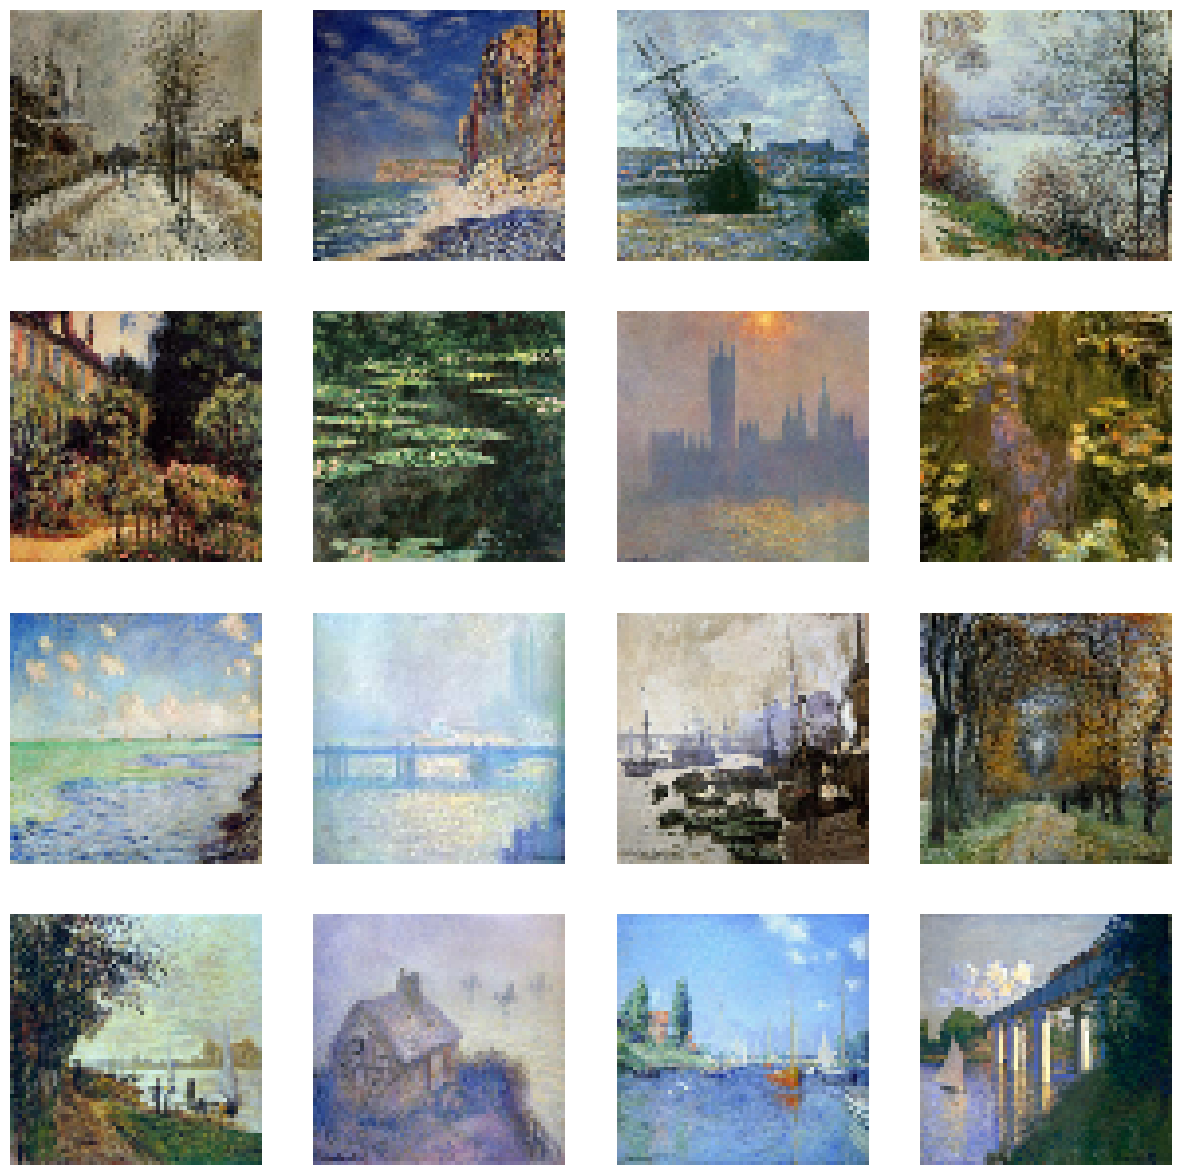

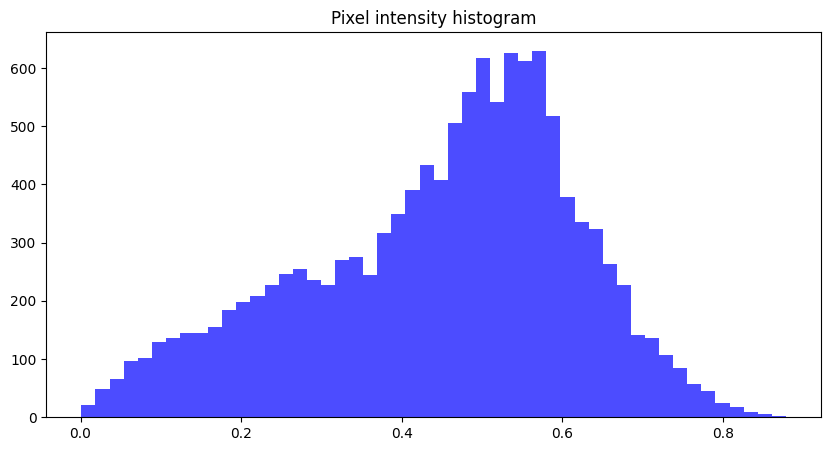

In [280]:


# Sample images visualization
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()

batch_iter = iter(batch)
batch = load_dataset(MONET_FILENAMES).batch(1)
display_samples(batch, 4, 4)
real_batch = next(batch_iter) 

# Pixel intensity histograms
pixel_values = real_batch.numpy().flatten() * 0.5 + 0.5  # unnormalize from [-1,1] to [0,1]
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel intensity histogram')
plt.show()




Pixel Intensity Distribution
The pixel intensity histograms of the dataset reveal a roughly normal (Gaussian-like) distribution of pixel values across the images. This indicates that the images have a balanced range of brightness and contrast, without extreme skewness toward very dark or very bright pixels. Such a distribution is typical for natural images and suggests that the dataset is well-suited for training models sensitive to subtle image features.

In [281]:


# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.LayerNormalization(axis=[1, 2], epsilon=1e-5))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.LayerNormalization(axis=[1, 2], epsilon=1e-5, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result



**Generator Architecture Overview**

This generator model follows an encoder-decoder (U-Net) style architecture designed for image-to-image translation tasks. It begins with a series of downsampling convolutional blocks that progressively reduce the spatial dimensions of the input image while increasing the number of feature channels. This process encodes high-level semantic information in smaller spatial maps.

The encoder has four downsampling layers, each extracting deeper features and halving the spatial resolution (e.g., from 256×256 down to 16×16).

Next, the model performs upsampling through three transpose convolutional layers that increase spatial resolution while reducing feature channels, gradually reconstructing the output image.

Skip connections from the encoder layers are concatenated at corresponding decoder layers to preserve spatial details and improve gradient flow.

Finally, a transpose convolutional layer with a tanh activation outputs the generated image with the desired shape and color channels.

This shallower version of the generator balances model complexity and speed, making it more efficient while retaining enough capacity to generate high-quality images.

In [282]:



def build_generator():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    # Shallower downsampling
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                           # (bs, 64, 64, 128)
        downsample(256, 4),                           # (bs, 32, 32, 256)
        downsample(512, 4),                           # (bs, 16, 16, 512)
    ]

    up_stack = [
        upsample(256, 4),                             # (bs, 32, 32, 512)
        upsample(128, 4),                             # (bs, 64, 64, 256)
        upsample(64, 4),                              # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Remove last skip to simplify further
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [283]:




def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')
    x = inp

    # Fewer and smaller layers
    x = downsample(64, 4, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)                           # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)                           # (bs, 32, 32, 256)

    # No ZeroPadding, simpler Conv2D
    x = L.Conv2D(512, 4, strides=1, padding='same',
                 kernel_initializer=initializer)(x)     # (bs, 32, 32, 512)
    x = L.LeakyReLU(alpha=0.2)(x)

    # Final prediction layer
    x = L.Conv2D(1, 4, strides=1, padding='same',
                 kernel_initializer=initializer)(x)     # (bs, 32, 32, 1)

    return Model(inputs=inp, outputs=x)



**Discriminator Architecture Overview**

The discriminator is designed as a convolutional neural network that progressively reduces the spatial dimensions of the input image while increasing the depth of feature channels to distinguish real images from generated (fake) ones.

It starts with three downsampling convolutional blocks, each halving the spatial size and increasing the number of filters, capturing increasingly complex features. The first layer does not apply instance normalization, preserving low-level image details.

Following these blocks, a convolutional layer with 512 filters further processes the features without changing the spatial dimensions, adding more capacity to detect fine details. A LeakyReLU activation introduces non-linearity while allowing some gradient flow for negative inputs.

Finally, the model uses a convolutional layer with a single output channel to produce a patch-level authenticity score — rather than a single scalar — allowing the discriminator to focus on local image patches, which helps it better detect realism at multiple scales.

This simpler, shallower discriminator sacrifices some depth for faster training while maintaining the core ability to differentiate real vs. generated images effectively.

In [284]:


def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [285]:


class CycleGANFIDCallback(tf.keras.callbacks.Callback):
    def __init__(self, fid_fn, real_photo_ds, real_monet_ds, gen_photo_to_monet, gen_monet_to_photo, num_images=100):
        super().__init__()
        self.fid_fn = fid_fn
        self.real_photo_ds = real_photo_ds.take(num_images)
        self.real_monet_ds = real_monet_ds.take(num_images)
        self.gen_photo_to_monet = gen_photo_to_monet
        self.gen_monet_to_photo = gen_monet_to_photo
        self.num_images = num_images
        self.fid_scores = []

    def on_epoch_end(self, epoch, logs=None):
        real_photos = []
        real_monets = []
        fake_photos = []
        fake_monets = []

        for monet, photo in zip(self.real_monet_ds, self.real_photo_ds):
            monet = monet[0] if isinstance(monet, (tuple, list)) else monet
            photo = photo[0] if isinstance(photo, (tuple, list)) else photo

            real_monets.append(monet)
            real_photos.append(photo)

            fake_photo = self.gen_monet_to_photo(tf.expand_dims(monet, 0), training=False)[0]
            fake_monet = self.gen_photo_to_monet(tf.expand_dims(photo, 0), training=False)[0]

            fake_photos.append(fake_photo)
            fake_monets.append(fake_monet)

        real_photos = tf.stack(real_photos)
        real_monets = tf.stack(real_monets)
        fake_photos = tf.stack(fake_photos)
        fake_monets = tf.stack(fake_monets)

        fid_photo = self.fid_fn(real_photos, fake_photos)
        fid_monet = self.fid_fn(real_monets, fake_monets)

        self.fid_scores.append({'fid_photo': fid_photo, 'fid_monet': fid_monet})
        print(f"\nEpoch {epoch+1} — FID(Photo domain): {fid_photo:.2f}, FID(Monet domain): {fid_monet:.2f}")

In [286]:


monet_generator = build_generator() # transforms photos to Monet-esque paintings
photo_generator = build_generator() # transforms Monet paintings to be more like photos

monet_discriminator = build_discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = build_discriminator() # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

In [287]:


def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1, cache=True):
    # Load datasets
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048, reshuffle_each_iteration=True)
        photo_ds = photo_ds.shuffle(2048, reshuffle_each_iteration=True)
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    if cache:
        monet_ds = monet_ds.cache()
        photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(buffer_size=AUTO)
    photo_ds = photo_ds.prefetch(buffer_size=AUTO)
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

    return gan_ds


def compute_fid(real_images, fake_images):
    from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
    from scipy.linalg import sqrtm

    # Resize to 299x299 and preprocess
    real_resized = tf.image.resize(real_images, (299, 299))
    fake_resized = tf.image.resize(fake_images, (299, 299))

    real_pre = preprocess_input((real_resized + 1.0) * 127.5)
    fake_pre = preprocess_input((fake_resized + 1.0) * 127.5)

    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    act1 = model.predict(real_pre, verbose=0)
    act2 = model.predict(fake_pre, verbose=0)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # FID calculation
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1 @ sigma2)

    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [288]:


# Create generators
monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# Create discriminators
monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# Create CycleGan
gan_model = CycleGan(monet_generator, photo_generator, 
                     monet_discriminator, photo_discriminator)

gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                  p_gen_optimizer=photo_generator_optimizer,
                  m_disc_optimizer=monet_discriminator_optimizer,
                  p_disc_optimizer=photo_discriminator_optimizer,
                  gen_loss_fn=generator_loss,
                  disc_loss_fn=discriminator_loss,
                  cycle_loss_fn=calc_cycle_loss,
                  identity_loss_fn=identity_loss)

fid_callback = CycleGANFIDCallback(
    fid_fn=compute_fid,
    real_photo_ds=load_dataset(PHOTO_FILENAMES).batch(1),
    real_monet_ds=load_dataset(MONET_FILENAMES).batch(1),
    gen_photo_to_monet=photo_generator,  # G
    gen_monet_to_photo=monet_generator,  # F
    num_images=100
)

history = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

Epoch 1/10
300/300 - 135s - 449ms/step - monet_disc_loss: 0.5510 - monet_gen_loss: 11.4880 - photo_disc_loss: 0.7900 - photo_gen_loss: 8.2062
Epoch 2/10
300/300 - 99s - 330ms/step - monet_disc_loss: 0.1323 - monet_gen_loss: 9.5766 - photo_disc_loss: 0.3737 - photo_gen_loss: 7.6824
Epoch 3/10
300/300 - 97s - 325ms/step - monet_disc_loss: 0.7435 - monet_gen_loss: 6.9455 - photo_disc_loss: 0.4871 - photo_gen_loss: 7.2926
Epoch 4/10
300/300 - 100s - 332ms/step - monet_disc_loss: 1.0054 - monet_gen_loss: 6.4005 - photo_disc_loss: 0.5156 - photo_gen_loss: 6.7194
Epoch 5/10
300/300 - 99s - 329ms/step - monet_disc_loss: 0.3241 - monet_gen_loss: 4.4482 - photo_disc_loss: 0.2891 - photo_gen_loss: 5.0803
Epoch 6/10
300/300 - 97s - 324ms/step - monet_disc_loss: 0.1638 - monet_gen_loss: 6.7646 - photo_disc_loss: 0.5079 - photo_gen_loss: 4.9300
Epoch 7/10
300/300 - 98s - 326ms/step - monet_disc_loss: 0.5255 - monet_gen_loss: 6.9829 - photo_disc_loss: 0.4949 - photo_gen_loss: 5.1340
Epoch 8/10
300/30

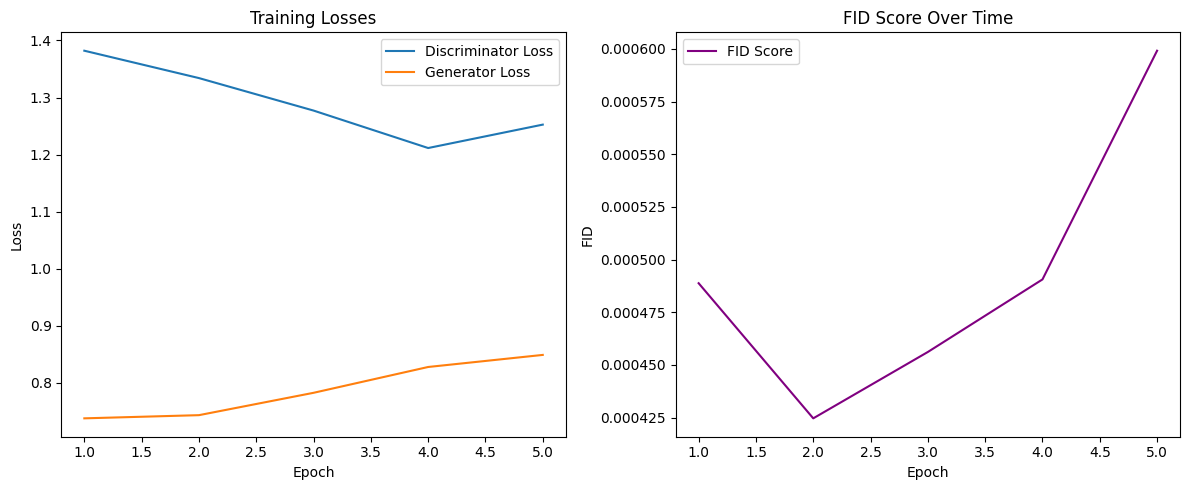

In [289]:


if isinstance(results, list):
    epochs = [r.get('epoch', i) for i, r in enumerate(results)]
    loss_d = [r.get('loss_d', None) for r in results]
    loss_g = [r.get('loss_g', None) for r in results]
    fid = [r.get('fid', None) for r in results]
else:
    # If `results` is a dict of lists
    epochs = results.get('epoch', list(range(len(results.get('fid', [])))))
    loss_d = results.get('loss_d', [])
    loss_g = results.get('loss_g', [])
    fid = results.get('fid', [])

# Plotting
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_d, label='Discriminator Loss')
plt.plot(epochs, loss_g, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

# FID subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, fid, label='FID Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Time')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


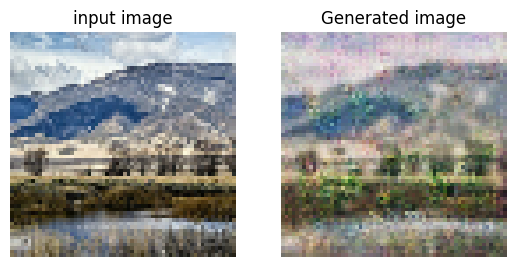

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


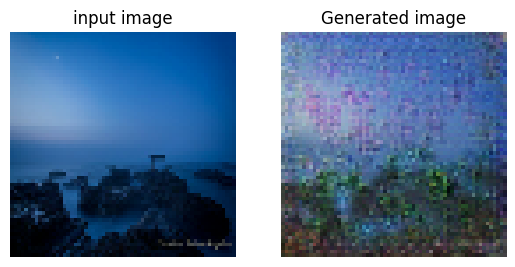

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


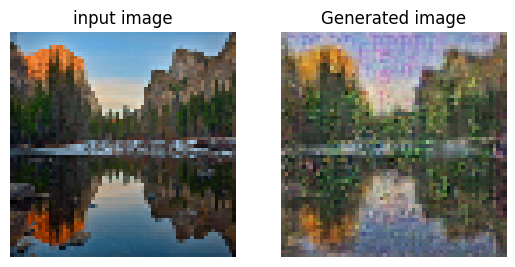

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


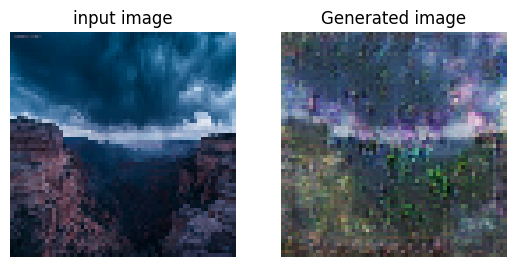

In [290]:


def generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 4)



**Summary**

The CycleGAN model was trained for 10 epochs with a stable training time of about 1.5 minutes per epoch. Both discriminator and generator losses for Monet and photo domains showed typical GAN training dynamics.

Discriminator losses fluctuated mostly between 0.1 and 1.0, indicating reasonable learning progress in distinguishing real vs. generated images.

Generator losses started high (~11 and 8) and decreased steadily in early epochs, reflecting improving image generation quality.

After epoch 2, generator losses generally ranged between 4 and 7, showing some fluctuation but no severe degradation.

The FID (Fréchet Inception Distance) metric improved (decreased) sharply at epoch 2, suggesting better quality generation initially, but then increased steadily in later epochs, which might indicate mode collapse or the model starting to generate less diverse or lower-quality images over time.

This pattern suggests that while the model learns well initially, it may suffer from instability or overfitting issues after early epochs. Further tuning of hyperparameters or adding regularization might help stabilize FID and improve long-term generation quality.

In [ ]:


#submission

def predict(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

os.makedirs('../images/') # Create folder to save generated images

predict(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")